# tf2 denoising autoencoder 로 MNIST Reconstruct 

* noise to the input

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU[0] is ready')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)
else:
    print('Please check GPU available')
    
import os
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
import tensorflow_datasets as tfds
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY 

GPU[0] is ready


In [7]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

# MNIST 데이터 확보

In [8]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
max_epochs = 50
learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
original_dim = 784

In [42]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = x_train_noisy.astype(np.float32)
x_test_noisy = x_test_noisy.astype(np.float32)


training_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train)).batch(batch_size)
training_dataset

<BatchDataset shapes: ((None, 784), (None, 784)), types: (tf.float32, tf.float32)>

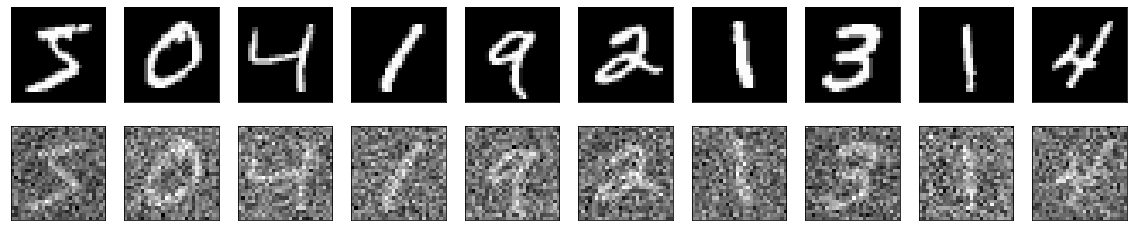

In [43]:
for x_noisy, x_original in training_dataset.take(1):   
    number = 10 
    plt.figure(figsize=(20,4))
    for index in range(number):
        # original
        ax = plt.subplot(2, number, index+1)
        plt.imshow(x_train[index].reshape(28,28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # noisy
        ax = plt.subplot(2, number, index+1+number)  # 다음 줄
        plt.imshow(x_train_noisy[index].reshape(28,28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    

# 모델 정의

In [44]:
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=hidden_dim, activation=tf.nn.relu)
        
    def call(self, input_features):
        x = self.hidden_layer(input_features)
        return x

class Decoder(tf.keras.layers.Layer):
    
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu)
        
    def call(self, encoded):
        x = self.output_layer(encoded)
        return x
    
class Autoencoder(tf.keras.Model):
    
    def __init__(self, hidden_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(original_dim=original_dim)
        
    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed
    
    
    
autoencoder = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
autoencoder.build(input_shape=(None, 784))
autoencoder.call(tf.keras.layers.Input(shape = (784)))
autoencoder.summary()  

Model: "autoencoder_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_9 (Encoder)          (None, 128)               100480    
_________________________________________________________________
decoder_9 (Decoder)          (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


# 학습

In [45]:
autoencoder = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)

autoencoder.compile(loss='mse', optimizer='adam')

loss = autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=max_epochs,
                batch_size=batch_size)

Epoch 1/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0520 - val_loss: 0.0344
Epoch 2/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0285
Epoch 3/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0272
Epoch 4/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.0267
Epoch 5/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0265
Epoch 6/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.0265
Epoch 7/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0264
Epoch 8/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0263
Epoch 9/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0262
Epoch 10/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0258

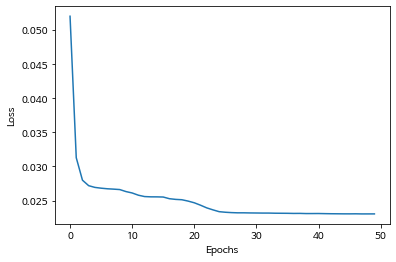

In [46]:
plt.plot(range(max_epochs), loss.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Reconstruct 시각화

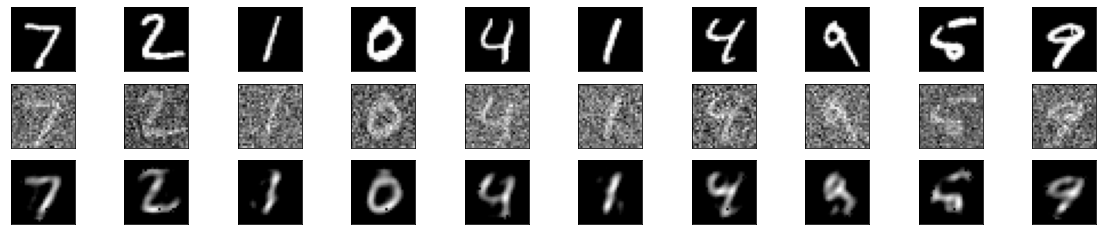

In [47]:
number = 10 
plt.figure(figsize=(20,4))
for index in range(number):
    # original
    ax = plt.subplot(3, number, index+1)
    plt.imshow(x_test[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # noisy
    ax = plt.subplot(3, number, index+1+number)
    plt.imshow(x_test_noisy[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # reconstructed
    ax = plt.subplot(3, number, index+1+number*2)  # 다음 줄
    plt.imshow(autoencoder(x_test_noisy)[index].numpy().reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()